In [7]:

import pandas as pd
import numpy as np
!python -m spacy download en_core_web_sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import spacy
import warnings
import sys
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# Set working directory
os.chdir(r'D:\10academy\Bank-reviews-analysis_W2\Bank-reviews-analysis')
sys.path.append(os.getcwd())  # Add the current working directory to Python's path
from scripts.preprocess_reviews import preprocess_reviews  # Import  preprocessing function
# Suppress warnings
warnings.filterwarnings("ignore")


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.4 MB/s eta 0:00:10
     -- ------------------------------------- 0.8/12.8 MB 1.4 MB/s eta 0:00:09
     --- ------------------------------------ 1.0/12.8 MB 1.3 MB/s eta 0:00:09
     ---- ----------------------------------- 1.3/12.8 MB 1.2 MB/s eta 0:00:10
     ---- ----------------------------------- 1.6/12.8 MB 1.1 MB/s eta 0:00:11
     ---- ----------------------------------- 1.6/12.8 MB 1.1 MB/s eta 0:00:11
     ----- ---------------------------------- 1.8/12.8 MB 1.1 MB/s eta 0:00:11
     ------ --------------------------------- 2.1/12.8 MB 1.1 MB/s eta 0:00:11
     ------- -------------------------------- 2.4/12.8 MB 1.1 MB/s eta 0:00:10
 

In [8]:
# Define the paths for cleaned data
banks = {
    "CBE": "notebooks/data/cleaned_CBE_reviews.csv",
    "BOA": "notebooks/data/cleaned_BOA_reviews.csv",
    "Dashen": "notebooks/data/cleaned_Dashen_reviews.csv"
}

# Initialize a dictionary to hold dataframes for each bank
bank_dataframes = {}

# Load each bank's data
for bank_name, path in banks.items():
    df = pd.read_csv(path)
    df['bank_name'] = bank_name  # Add a bank name column
    bank_dataframes[bank_name] = df
    print(f"Loaded data for {bank_name}:")
    print(df.head(), "\n")

Loaded data for CBE:
                                         review_text  rating        date  \
0  "Why don’t your ATMs support account-to-accoun...       4  2025-06-06   
1                        what is this app problem???       1  2025-06-05   
2       the app is proactive and a good connections.       5  2025-06-05   
3    I cannot send to cbebirr app. through this app.       3  2025-06-05   
4                                               good       4  2025-06-05   

  bank_name       source  
0       CBE  Google Play  
1       CBE  Google Play  
2       CBE  Google Play  
3       CBE  Google Play  
4       CBE  Google Play   

Loaded data for BOA:
                                         review_text  rating        date  \
0                                   it's not working       3  2025-06-05   
1  Hello, I’m facing a problem with the BOA Mobil...       1  2025-06-03   
2                                        exceptional       5  2025-06-03   
3                    this is wore

In [9]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    doc = nlp(text)
    # Remove stop words and retain lemmatized tokens
    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and token.is_alpha]
    return ' '.join(tokens)

# Apply preprocessing to each bank's reviews
for bank_name, df in bank_dataframes.items():
    df['processed_review'] = df['review_text'].apply(preprocess_text)
    print(f"Preprocessed reviews for {bank_name}:\n", df[['review_text', 'processed_review']].head(), "\n")

Preprocessed reviews for CBE:
                                          review_text  \
0  "Why don’t your ATMs support account-to-accoun...   
1                        what is this app problem???   
2       the app is proactive and a good connections.   
3    I cannot send to cbebirr app. through this app.   
4                                               good   

                                    processed_review  
0  why atm support account account transfer like ...  
1                                        app problem  
2                      app proactive good connection  
3                             I send cbebirr app app  
4                                               good   

Preprocessed reviews for BOA:
                                          review_text  \
0                                   it's not working   
1  Hello, I’m facing a problem with the BOA Mobil...   
2                                        exceptional   
3                    this is worest app 24/7 

In [10]:
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(review):
    sentiment = analyzer.polarity_scores(review)
    return sentiment['compound']

def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

def perform_sentiment_analysis(df):
    df['sentiment_score'] = df['processed_review'].apply(analyze_sentiment)
    df['sentiment'] = df['sentiment_score'].apply(classify_sentiment)
    return df

# Apply sentiment analysis to each bank's reviews
for bank_name, df in bank_dataframes.items():
    df = perform_sentiment_analysis(df)
    print("Sentiment Analysis Results for", bank_name, ":\n", df[['processed_review', 'sentiment_score', 'sentiment']].head(), "\n")

Sentiment Analysis Results for CBE :
                                     processed_review  sentiment_score  \
0  why atm support account account transfer like ...           0.6369   
1                                        app problem          -0.4019   
2                      app proactive good connection           0.6908   
3                             I send cbebirr app app           0.0000   
4                                               good           0.4404   

  sentiment  
0  positive  
1  negative  
2  positive  
3   neutral  
4  positive   

Sentiment Analysis Results for BOA :
                                     processed_review  sentiment_score  \
0                                               work           0.0000   
1  hello I face problem BOA Mobile app every time...          -0.1027   
2                                        exceptional           0.0000   
3                                    wor app loading           0.0000   
4      this App interest Android p

In [11]:
def extract_keywords(df):
    vectorizer = TfidfVectorizer(max_features=100)
    X = vectorizer.fit_transform(df['processed_review'])
    return vectorizer.get_feature_names_out()

# Define themes based on keywords
def cluster_keywords(keywords):
    themes = {
        "Account Access Issues": ["login", "access", "error"],
        "Transaction Performance": ["transfer", "delay", "slow"],
        "User Interface & Experience": ["UI", "design", "easy"],
        "Customer Support": ["support", "help", "service"],
        "Feature Requests": ["feature", "request", "add"]
    }
    return themes

# Apply keyword extraction and thematic analysis for each bank
for bank_name, df in bank_dataframes.items():
    keywords = extract_keywords(df)
    print(f"Top Keywords for {bank_name}:", keywords, "\n")
    
    themes = cluster_keywords(keywords)
    print("Identified Themes for", bank_name, ":", themes, "\n")

Top Keywords for CBE: ['access' 'account' 'add' 'allow' 'amazing' 'app' 'application' 'bad'
 'bank' 'banking' 'cbe' 'connection' 'consent' 'convenient' 'corporation'
 'coz' 'crash' 'customer' 'day' 'developer' 'easy' 'excellent'
 'experience' 'fantastic' 'fast' 'feature' 'fix' 'friendly'
 'functionality' 'good' 'great' 'issue' 'it' 'job' 'life' 'like' 'love'
 'make' 'mobile' 'money' 'mpesa' 'need' 'network' 'nice' 'not' 'old'
 'option' 'payment' 'problem' 'reason' 'reliable' 'remove' 'safaricom'
 'satisfied' 'screen' 'screenshot' 'secure' 'security' 'see' 'send'
 'service' 'shot' 'simple' 'simply' 'smart' 'step' 'stop' 'suitable'
 'super' 'support' 'sure' 'sync' 'system' 'take' 'telebirr' 'thank'
 'thankyou' 'the' 'thing' 'this' 'time' 'transaction' 'transfer' 'try'
 'update' 'use' 'useful' 'user' 'very' 'way' 'week' 'well' 'work' 'wow'
 'yes' 'you' 'በጣም' 'ነው' 'ግን' 'ጥሩ'] 

Identified Themes for CBE : {'Account Access Issues': ['login', 'access', 'error'], 'Transaction Performance': ['t

In [12]:
for bank_name, df in bank_dataframes.items():
    df.to_csv(f'notebooks/data/processed_reviews_{bank_name}.csv', index=False)
    print(f"Processed data for {bank_name} saved to CSV.\n")

Processed data for CBE saved to CSV.

Processed data for BOA saved to CSV.

Processed data for Dashen saved to CSV.



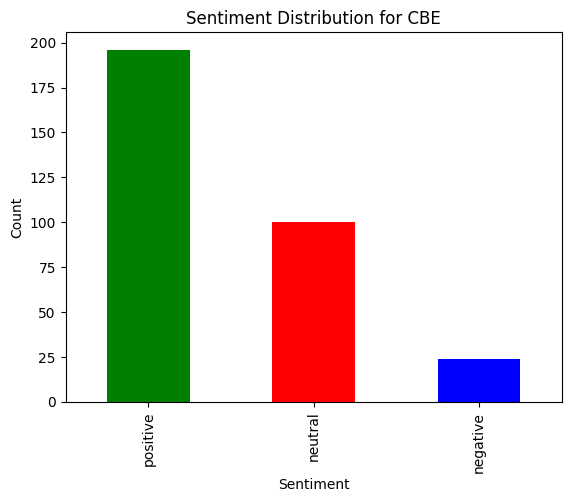

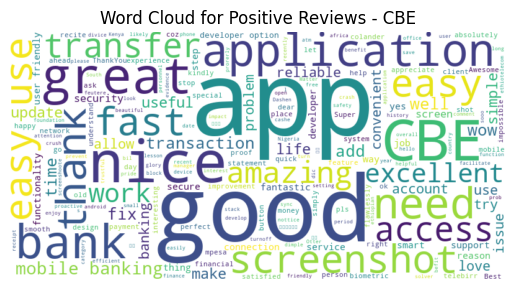

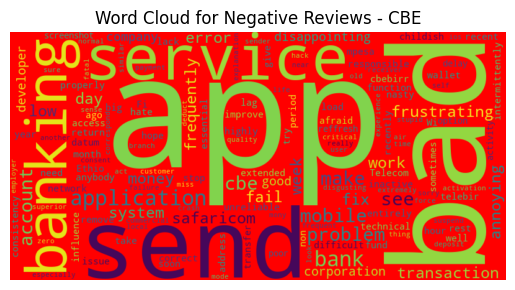

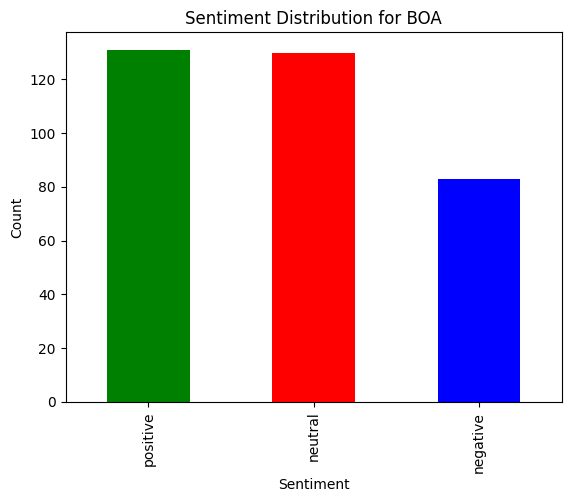

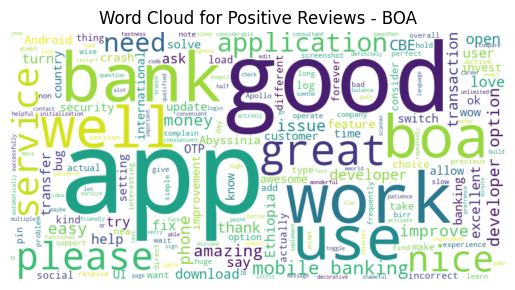

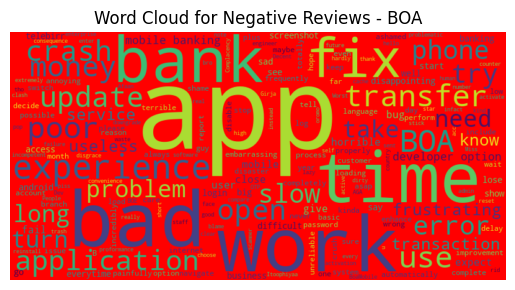

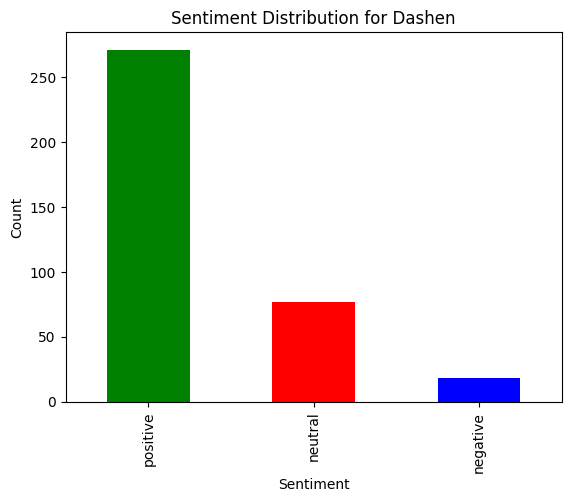

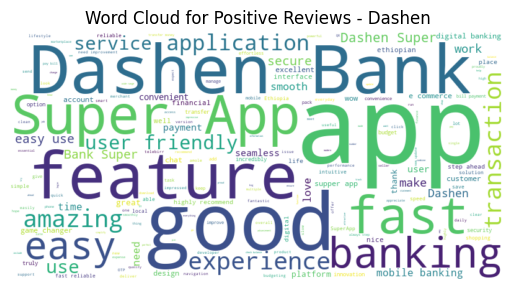

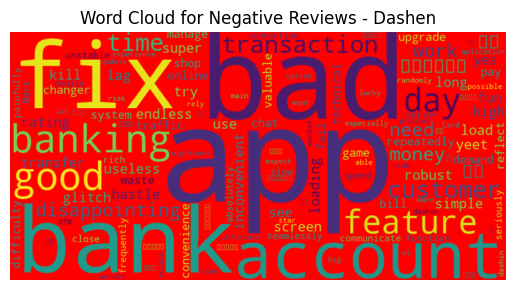

In [13]:
for bank_name, df in bank_dataframes.items():
    # Sentiment Distribution
    df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
    plt.title(f'Sentiment Distribution for {bank_name}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

    # Word Cloud for Positive Reviews
    positive_reviews = df[df['sentiment'] == 'positive']['processed_review']
    positive_text = ' '.join(positive_reviews)
    wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Positive Reviews - {bank_name}')
    plt.show()

    # Word Cloud for Negative Reviews
    negative_reviews = df[df['sentiment'] == 'negative']['processed_review']
    negative_text = ' '.join(negative_reviews)
    wordcloud_neg = WordCloud(width=800, height=400, background_color='red').generate(negative_text)
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Negative Reviews - {bank_name}')
    plt.show()